In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm 
import copy

import warnings
import tqdm
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
import torchvision
from torch.utils.data import DataLoader

from utils import *
from sklearn.model_selection import KFold, ShuffleSplit


In [2]:
random_state = 42
SEED = random_state

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gen = torch.manual_seed(random_state)
device

device(type='cpu')

In [3]:
class BaseNet(nn.Module):
    
    def __init__(self) -> None:
        super(BaseNet, self).__init__()
        self.train_error = []
        self.val_error = []
        self.test_error = []
        self.best_epoch = 0
        self._EPOCH_MAX = 5 * 10000
        self._EPOCH_CHECK = 100

In [4]:
class Coder3(BaseNet):

    def __init__(self, input_size, hidden_layers, hidden_dim, seed) -> None:
        super(Coder3, self).__init__()
        
        assert len(hidden_layers) == 3
        self.hidden_dim = hidden_dim
        
        self.layer1 = nn.Linear(input_size, hidden_layers[0]) 
        torch.manual_seed(seed)
        nn.init.xavier_uniform_(self.layer1.weight)   

        
        self.layer2 = nn.Linear(hidden_layers[0], hidden_layers[1], bias=False)  
        torch.manual_seed(seed)
        nn.init.xavier_uniform_(self.layer2.weight) 

        self.layer3 = nn.Linear(hidden_layers[1], hidden_layers[2], bias=False) 
        torch.manual_seed(seed)
        nn.init.xavier_uniform_(self.layer3.weight)  
        
        self.layer4 = nn.Linear(hidden_layers[2], hidden_dim, bias=False) 
        torch.manual_seed(seed)
        nn.init.uniform_(self.layer4.weight) 
        
        self.relu = nn.ReLU()
        self.elu = nn.ELU()
    

class Encoder3(Coder3):    
    def __init__(self, batch_size, *args, **kwargs) -> None:
        self.batch_size = batch_size
        super(Encoder3, self).__init__(*args, **kwargs)
        
    def noiser(self, z_log_var, z_mean):
        N = torch.normal(mean=0., std=1., size=(z_log_var.shape[0], self.hidden_dim))
        return torch.exp(z_log_var / 2) * N + z_mean
        
            
    def forward(self, x, y):
        inp = torch.concat([x, y], dim=1)
        out = self.layer1(inp)
        out = self.relu(out)
        
        out = self.layer2(out)
        out = self.relu(out)
        
        out = self.layer3(out)
        out = self.relu(out)

        z_mean = self.layer4(out)
        z_log_var = self.layer4(out)
        
        h = self.noiser(z_log_var, z_mean)
        return h, z_log_var, z_mean
    

class Decoder3(Coder3):    
    def __init__(self, batch_size, *args, **kwargs) -> None:
        self.batch_size = batch_size
        super(Decoder3, self).__init__(*args, **kwargs)        
            
    def forward(self, x_normal, y):
        inp = torch.concat([x_normal, y], dim=1)
        out = self.layer1(inp)
        out = self.elu(out)
        
        out = self.layer2(out)
        out = self.elu(out)
        
        out = self.layer3(out)
        out = self.elu(out)

        out = self.layer4(out)        
        return out
    
    
class CVAE(BaseNet):

    def __init__(self, x_size, hidden_layers, hidden_dim, y_size, batch_size, seed) -> None:
        super(CVAE, self).__init__() 
        self.batch_size = batch_size
        self.input_size = x_size + y_size
        self.hidden_dim = hidden_dim
        self.encoder = Encoder3(self.batch_size, self.input_size, hidden_layers, self.hidden_dim, seed=seed)
        self.decoder = Decoder3(self.batch_size, y_size + self.hidden_dim, hidden_layers, x_size, seed=seed)
    
    def get_loss(self, x, y, z_log_var, z_mean):
        loss = torch.sum(torch.square(x-y), axis=-1)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - torch.square(z_mean) - torch.exp(z_log_var), axis=-1)
        return torch.mean(loss + kl_loss)
    
    def cacl_err(self, data_loader, loss):
        with torch.no_grad():
            X, y = data_loader.get_transformed_data()

            out, z_log_var, z_mean = self(X, y)
            #out[predict < 0] = 0
            #out[predict > 4] = 4
            return loss(self, X, out, z_log_var, z_mean).item()
    
    def forward(self, x, y):
        h, z_log_var, z_mean = self.encoder(x, y)
        out = self.decoder(h, y)
        return out, z_log_var, z_mean
    
    
    def fit(self, dataset, train_vall_index, test_index, optimizer, path, conf):
        
        train_data, val_data, test_data = train_val_test_split(
            dataset, train_vall_index, test_index,
            vall_ratio=0.22,
        )
        prev_model = {'loss': 10**6}
        train_loader = DataLoader(train_data, batch_size=self.batch_size, generator=gen)
        
        for epoch in tqdm.tqdm(range(self._EPOCH_MAX), desc='EPOCHES'):
            
            track_loss = []
            for X_train, y_train in train_loader:  
                predict, z_log_var, z_mean = self(X_train,y_train)
                loss = self.get_loss(predict, X_train, z_log_var, z_mean)
                track_loss.append(loss.detach())

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

           
            train = np.mean(track_loss)
            val = self.cacl_err(val_data, CVAE.get_loss)
            test = self.cacl_err(test_data, CVAE.get_loss)
            self.train_error.append(train)
            self.val_error.append(val)
            self.test_error.append(test)
            
            epochs_left = epoch + 1
            if self.val_error[-1] < prev_model['loss'] and (epochs_left - self.best_epoch) < self._EPOCH_CHECK:
                prev_model = {
                    'loss': self.val_error[-1],
                    'path': f'{path}/tmp/model-{conf}-saved.pt',
                    'epoch': epochs_left,
                }
                self.best_epoch = epochs_left
                torch.save(self, prev_model['path'])
            elif (epoch - self.best_epoch) >= self._EPOCH_CHECK:
                break

        model = torch.load(prev_model['path'])
        model = model.eval()
        model.train_error = copy.deepcopy(self.train_error)
        model.val_error = copy.deepcopy(self.val_error)
        model.test_error = copy.deepcopy(self.test_error)
        return model

In [5]:
path = './models/cvae-(256, 126, 32)-0.pt'

model = torch.load(path)
model.eval()
batch_size = 64

In [6]:
x_path = f'./data/OA/x_data.csv'
y_path = './data/OA/y_data.csv'

transformer = MinMaxTransform()

dataset = DataProcessor(
    x_path=x_path, 
    y_path=y_path, 
    transformer=transformer
)

transformer.fit(dataset)

Best epoch: 1137


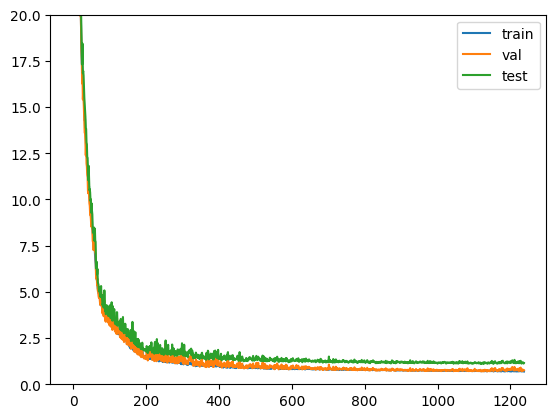

In [7]:
plt.plot(model.train_error, label='train')
plt.plot(model.val_error, label='val')
plt.plot(model.test_error, label='test')
plt.legend()
plt.ylim([0, 20])
print(f"Best epoch: {model.best_epoch}")
plt.show()

In [8]:
X, y = dataset.get_transformed_data()

with torch.no_grad():
    predict, z_log_var, z_mean = model(X, y)

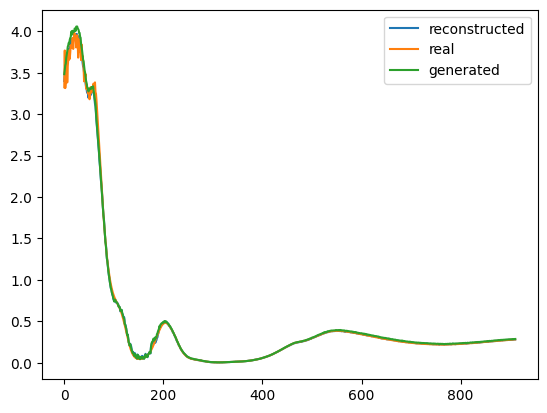

In [76]:
sample = predict.detach()

reconstructed = transformer.inverse_transformX(sample)

n = 719

h = torch.normal(mean=0., std=1., size=(1, 16))
y_sample = torch.reshape(y[n], (1, -1))
generated_scaled = model.decoder(h, y_sample).detach()

generated = transformer.inverse_transformX(generated_scaled)


real = transformer.inverse_transformX(X)





plt.plot(reconstructed[n], label='reconstructed')
plt.plot(real[n], label='real')
plt.plot(generated[0], label='generated')
plt.legend()
plt.show()

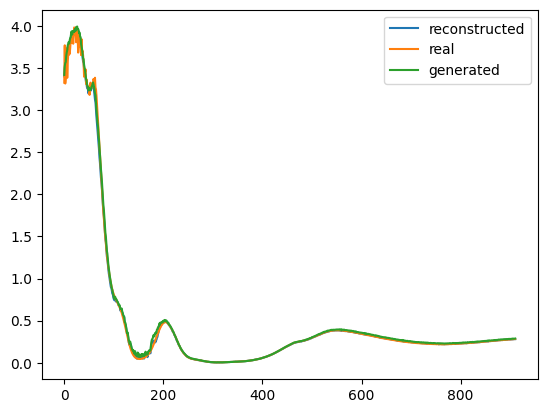

In [77]:
sample = predict.detach()

reconstructed = transformer.inverse_transformX(sample)

n = 719

h = torch.normal(mean=0., std=1., size=(1, 16))
y_sample = torch.reshape(y[n], (1, -1))
generated_scaled = model.decoder(h, y_sample).detach()

generated = transformer.inverse_transformX(generated_scaled)


real = transformer.inverse_transformX(X)





plt.plot(reconstructed[n], label='reconstructed')
plt.plot(real[n], label='real')
plt.plot(generated[0], label='generated')
plt.legend()
plt.show()

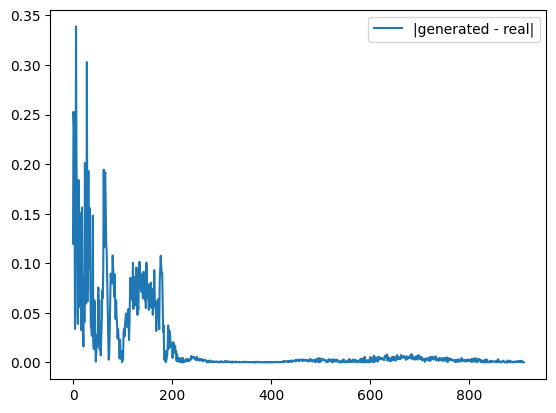

In [45]:
plt.plot(np.abs(generated[0] - real[n]), label='|generated - real|')
plt.legend()
plt.show()

In [20]:
class Discriminator3(Coder3):    
    def __init__(self, batch_size, *args, **kwargs) -> None:
        self.batch_size = batch_size
        # self.batch_norm1 = nn.BatchNorm1d(hidden_dim[0]) #affine=False without train params
        # self.batch_norm2 = nn.BatchNorm1d(hidden_dim[1])
        # self.batch_norm3 = nn.BatchNorm1d(hidden_dim[2])
        super(Discriminator3, self).__init__(*args, **kwargs)        
            
    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        
        out = self.layer2(out)
        out = self.relu(out)
        
        out = self.layer3(out)
        out = self.relu(out)

        out = self.layer4(out)        
        return out

class GAN(BaseNet):
    def __init__(self, x_size, hidden_layers, hidden_dim, y_size, batch_size, seed) -> None:
        super(GAN, self).__init__() 
        self.batch_size = batch_size
        self.input_size = x_size + y_size
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self._EPOCH_MAX = 2000
        self.generator = CVAE(x_size, hidden_layers, hidden_dim, y_size, batch_size, seed=seed)
        self.discriminator = Discriminator3(self.batch_size, x_size, hidden_layers, y_size, seed=seed)
    
    def __ones(self, rows, cols):
        return torch.ones_like(torch.empty(rows, cols))
        
    
    def __generator_loss(self, cross_entropy, fake_output, z_log_var, z_mean):
        ones =  torch.ones_like(torch.empty(fake_output.size()))
        loss = cross_entropy(ones, fake_output)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - torch.square(z_mean) - torch.exp(z_log_var), axis=-1)
        return torch.mean(loss + kl_loss)


    def __discriminator_loss(self, cross_entropy, real_output, fake_output):
        ones = torch.ones_like(torch.empty(fake_output.size()))
        real_loss = cross_entropy(ones, real_output)
        fake_loss = cross_entropy(ones, fake_output)
        return real_loss + fake_loss
    
    
    def cacl_err(self, cross_entropy, data):
        with torch.no_grad():
            X, y = data.get_transformed_data()
            # generator predict
            gen_x, z_log_var, z_mean = self.generator(X, y)
                
            # calc error with discriminator
            real_output = self.discriminator(X) 
            fake_output = self.discriminator(gen_x)
                
            gen_loss = self.__generator_loss(cross_entropy, fake_output, z_log_var, z_mean).item()
            disc_loss = self.__discriminator_loss(cross_entropy, real_output, fake_output).item()
            return (gen_loss, disc_loss)
    
    def forward(self, x, y):
        h, z_log_var, z_mean = self.generator(x, y)
        out = self.decoder(h, y)
        return out, z_log_var, z_mean
    
    def fit(self, dataset, train_vall_index, test_index, gen_optimizer, disc_optimizer, path, conf):
        
        train_data, val_data, test_data = train_val_test_split(
            dataset, train_vall_index, test_index,
            vall_ratio=0.22,
        )
        prev_model = {'loss': 10**6}
        cross_entropy = nn.BCELoss()
        train_loader = DataLoader(train_data, batch_size=self.batch_size, generator=gen)
        
        for epoch in tqdm.tqdm(range(self._EPOCH_MAX), desc='EPOCHES'):
            
            loss_hist = [] # (gen_loss, disc_loss)
            for X_train, y_train in train_loader:  
                
                # train generator
                gen_x, z_log_var, z_mean = self.generator(X_train, y_train)
                fake_output = self.discriminator(gen_x)
                
                gen_loss = self.__generator_loss(cross_entropy, fake_output, z_log_var, z_mean)
                
                gen_optimizer.zero_grad()
                gen_loss.backward()
                gen_optimizer.step()
                
                # train discriminator
                real_output = self.discriminator(X_train) 
                
                gen_x, z_log_var, z_mean = self.generator(X_train, y_train)
                fake_output = self.discriminator(gen_x)
                
                disc_loss = self.__discriminator_loss(cross_entropy, real_output, fake_output)
                
                disc_optimizer.zero_grad()
                disc_loss.backward()
                disc_optimizer.step()
                
                
                # track loss
                loss_hist.append(
                    (gen_loss.detach(), disc_loss.detach())
                )
                
            # track train, val, test loss            
            self.train_error.append(
                np.mean(loss_hist, axis=0)
            )
            self.val_error.append(
                self.cacl_err(cross_entropy, val_data)
            )
            self.test_error.append(
                self.cacl_err(cross_entropy, test_data)
            )
            
            #epochs_left = epoch + 1
            #if self.val_error[-1][1] < prev_model['loss'][1] and (epochs_left - self.best_epoch) < self._EPOCH_CHECK:
            #    prev_model = {
            #        'loss': self.val_error[-1],
            #        'path': f'{path}/tmp/gan-{conf}-saved.pt',
            #        'epoch': epochs_left,
            #    }
            #    self.best_epoch = epochs_left
            #    torch.save(self, prev_model['path'])
            #elif (epoch - self.best_epoch) >= self._EPOCH_CHECK:
            #    break

        #model = torch.load(prev_model['path'])
        #model = model.eval()
        #model.train_error = copy.deepcopy(self.train_error)
        #model.val_error = copy.deepcopy(self.val_error)
        #model.test_error = copy.deepcopy(self.test_error)
        #return model
        return self
    

In [30]:
path = './models/gan-(256, 126, 32)-1.pt'

gan = torch.load(path)
gan.eval()
print()

In [ ]:
plt.plot(gan.train_error, label='train')
plt.plot(model.val_error, label='val')
plt.plot(model.test_error, label='test')
plt.legend()
plt.ylim([0, 20])
print(f"Best epoch: {model.best_epoch}")
plt.show()

In [73]:
a = 'Zn Cu Li Fe Ni NH4 SO4 NO3'


Zn = (0.06, 0.055, 0.063)
Cu = (0.022, 0.02, 0.026)
Li = (0.11, 0.105, 0.104)
Fe = (0.051, 0.039, 0.043)
Ni = (0.055, 0.035, 0.046)
NH4 = (0.145, 0.135, 0.146)
SO4 = (0.121, 0.125, 0.126)
NO3 = (0.161, 0.145, 0.166)

r = [Zn, Cu, Li, Fe, Ni, NH4, SO4, NO3]

al = []
for el in r:
    mu, sigma = el[2], np.random.rand() / 100
    res = np.random.normal(mu, sigma, 27)
    res = np.append(res, [mu, sigma])
    al.append(res)

In [74]:
df=pd.DataFrame(
    al,
    index=a.split()
)
df.to_excel('reduced.xlsx')

In [55]:
np.random.rand() / 100

0.008593490502203741

In [56]:
1 / 100

0.01